# **Kaggle / Titanic, Machine Learning from Disaster**

## **Tutorial competition description**

From [Kaggle](https://www.kaggle.com/c/titanic) :
<br> <br>
*The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.*

*One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.*

*In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.*

#### *Key skills* : Exploratory data analysis, Data cleaning, Binary Classification, Ensemble methods

### **Set up**

#### **Importing librairies**

In [1]:
import sys, os
import re
from six.moves import urllib
import numpy as np
import pandas as pd
from pandas.core.common import SettingWithCopyWarning
import re
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display #to have nice dataframe in Jupyter notebook

import seaborn as sns
import itertools
import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict
from scipy.stats import uniform, randint, expon, reciprocal
from sklearn.externals import joblib
from statsmodels.distributions.empirical_distribution import ECDF
import xgboost as xgb

import warnings

In [2]:
print("Python interpreter : ", sys.version)
print("Numpy version : ", np.__version__)
print("Pandas version : ", pd.__version__)
print("Matplotlib version : ", matplotlib.__version__)
print("Seaborn version : ", sns.__version__)
print("Scikit learn version : ", sklearn.__version__)
print("XGboost version : ", xgb.__version__)

Python interpreter :  3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]
Numpy version :  1.16.3
Pandas version :  0.24.2
Matplotlib version :  3.0.3
Seaborn version :  0.9.0
Scikit learn version :  0.20.3
XGboost version :  0.82


In [3]:
warnings.simplefilter(action='ignore', category=(FutureWarning, SettingWithCopyWarning))
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100)
URL_ROOT_PATH = 'https://raw.githubusercontent.com/GuillaumeHarel/Hello_world_ML/master/Raw_data/Kaggle_titanic/'
FILE_NAMES = ['train.csv', 'test.csv']
MODEL_SAVING_PATH = "./Models/"
DATA_SAVING_PATH = "./Data/"

### **Downloading the data**

In [4]:
def fetch_datasets(dl_root = URL_ROOT_PATH, file_path=DATA_SAVING_PATH):
    datasets = {}
    if os.path.exists(file_path):
        print("Files were previously downloaded, loading file from: ", file_path)
        for root, dirs, files in os.walk(file_path):
            for file in files:
                datasets[file] = pd.read_csv(os.path.join(root, file), index_col=0)
        return datasets
    os.makedirs(file_path)
    for file_name in FILE_NAMES:
        dl_url = URL_ROOT_PATH + file_name
        file_path = DATA_SAVING_PATH + file_name
        urllib.request.urlretrieve(dl_url, file_path)
        print("{} has been successfully donwloaded and saved in {}".format(file_name, file_path))
        print('~-'*30)
        datasets[file_name] = pd.read_csv(file_path, index_col=0)
    return datasets
        

In [5]:
datasets = fetch_datasets()

Files were previously downloaded, loading file from:  ./Data/


In [6]:
print(datasets.keys())
for file in FILE_NAMES:
    print(datasets[file].shape)
    display(datasets[file].head(3))

dict_keys(['test.csv', 'train.csv'])
(891, 11)


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


(418, 10)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


### **Exploratory Data Analysis**

In [7]:
df_train = datasets['train.csv']
df_test = datasets['test.csv']
print(df_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None


Object dtype corresponds to strings while int64 et float64 object respectively stands for numeric categorical features and numeric continuous features. Survived viariable is the target variable we want to predict for the test dataset. 
Meaning of each feature is quickly indicated below :


    Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
    Pclass: passenger class.
    Name, Sex, Age: self-explanatory
    SibSp: how many siblings & spouses of the passenger aboard the Titanic.
    Parch: how many children & parents of the passenger aboard the Titanic.
    Ticket: ticket id
    Fare: price paid (in pounds)
    Cabin: passenger's cabin number
    Embarked: where the passenger embarked the Titanic



From the .info method, some missing values (NaN values) can be observed for the Age (about roughly 20%) and for the Cabin number (> 75%). Two values are also missing for the Embarked feature. For these 3 features, missing values will have to be inmputed in order to be included in the model. Let's have a closer look at the train df head.

In [8]:
display(df_train.head(10))

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S


Cabin number feature might be a relevant feature since it might provide useful information on cabin location (e.g. top deck) but the low proportion of available data is trully an issue since missing values can hardly be imputed from other features. I will be likely to drop this feature.
<br> <br>
About the string features :
<br>
Ticket feature does not seem very useful at first sight. Although it might contain information (e.g. "PC" must stands for Premiere Class), most of them appear redundant with other features and the information format seems to vary a lot. The only useful information I could think off would be to link passenger between themselves (provided group of people can travel with a same ticket ?).
<br>
Name feature present a few information that might be useful like the name (to link family member/spouse) or a specific "title" (eg. "Miss") bringing extra information on the social status or age.


Let's quickly go through continuous and categorical feature before digging into EDA

In [9]:
th_total_pass_nb = 2224
th_total_death = 1502
th_SR = (th_total_pass_nb - th_total_death)/th_total_pass_nb
data_total_pass_nb = len(df_train) + len(df_test)
mean_train_SR = df_train['Survived'].mean()
print("Total nb of passengers in the dataset: {} VS {} passengers + crew reported in records".format(data_total_pass_nb, th_total_pass_nb))
print("Mean survival rate - train set: {:.1f}% VS real records : {:.1f}%".format(mean_train_SR*100, th_SR*100))


Total nb of passengers in the dataset: 1309 VS 2224 passengers + crew reported in records
Mean survival rate - train set: 38.4% VS real records : 32.5%


Here I guess that many of "missing" passengers in the dataset correspond to crew members. Some passengers must probably still have been discarded from the dataset because of poor/unavailable data. At some point I think I read somewhere that the list of passengers and corresponding information were issued from an hand-written embarkation registry partially found after the shipwreck.

In [10]:
display(df_train[['Age', 'Fare']].describe())

,Age,Fare
count,714.000000,891.000000
mean,29.699118,32.204208
std,14.526497,49.693429
min,0.420000,0.000000
25%,20.125000,7.910400
50%,28.000000,14.454200
75%,38.000000,31.000000
max,80.000000,512.329200


In [11]:
cat_features = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
for feat in cat_features:
    display(df_train[feat].value_counts())

0    549
1    342
Name: Survived, dtype: int64

3    491
1    216
2    184
Name: Pclass, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [12]:
display(df_train['Ticket'].value_counts()[:10])

347082          7
CA. 2343        7
1601            7
CA 2144         6
347088          6
3101295         6
382652          5
S.O.C. 14879    5
4133            4
PC 17757        4
Name: Ticket, dtype: int64

Thus a single ticket can be used for a group of passenger traveling together.

### **Studying Survival rate through categorical features**

*Survival Rate VS Sex, Embarked and Pclass*

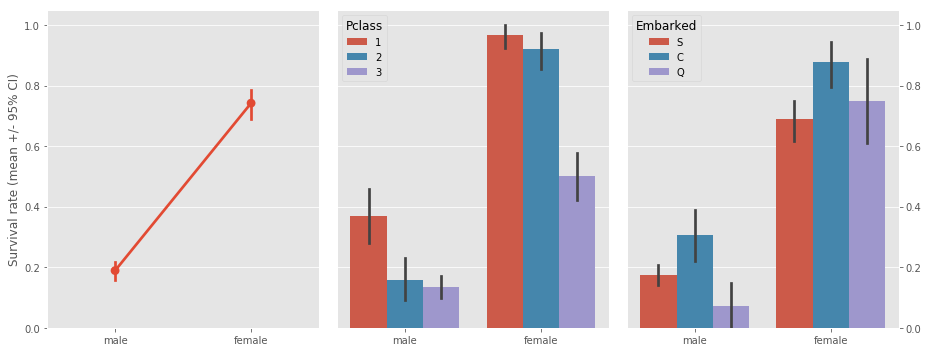

In [13]:
fig, axarr = plt.subplots(1,3, sharey=True, figsize=(13, 5))
sns.pointplot(x='Sex', y='Survived', data=df_train, ax=axarr[0])
axarr[0].set(ylabel='Survival rate (mean +/- 95% CI)', xlabel='')
sns.catplot(x='Sex', y='Survived', hue='Pclass', data=df_train, ax=axarr[1], kind='bar')
axarr[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
axarr[1].set(ylabel='', xlabel='')
sns.catplot(x='Sex', y='Survived', hue='Embarked', data=df_train, ax=axarr[2], kind='bar')
axarr[2].tick_params(axis='y', which='both', left=False, right=True, labelleft=False, labelright=True)
axarr[2].set(ylabel='', xlabel='')
plt.close(2)
plt.close(3)
plt.tight_layout()
plt.show()

There is a huge statistically significant difference for the mean survival rate between men and women (roughly 20% VS 80 %!). As a result, the graphical EDA will be conducted through this dichotomy. <br>
The PClass seems to also play an important role for the mean survival rate for both men and women. <br>
The right graph would suggest that people who embarked at Cherbourg in France were more likely to survive than their american counterpart. I don't see any particular logical reason to that apart from the hypothesis of a specific or 'advantageous' allocation of the cabins for people embarking at Cherbourg. Let's double check with the distribution of embarking dock according to PClass. 


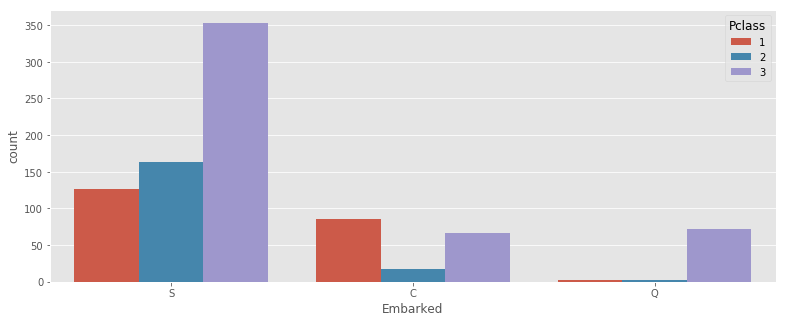

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(13,5))
sns.countplot(x='Embarked', hue='Pclass', data=df_train)
plt.close(2)
plt.show()

Distribution for embarkation deck along PClass is quite heterogenous... About half of people who embarked at Cherbourg were in Pclass 1, hence the highest survival rate looking back at the previous figure. The Embarked feature might not be very relevant for our model, let's decide that later.

**Feature engineering** 

*Survival Rate VS Family*

SibSp and Parch are not very convenient features since they kind of mix "opposite" attributes into a single (or at least that might have been more useful if separated). Let's combine the whole thing into a single feature called "Family" representing the number of people from its family one is traveling with !

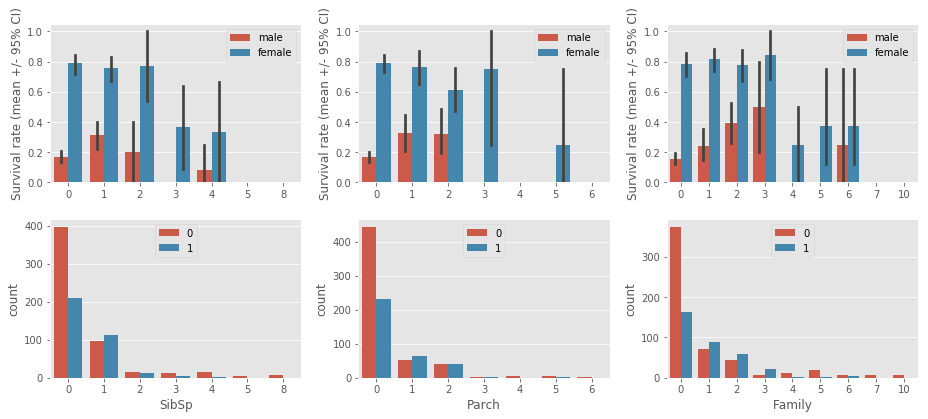

In [15]:
df_train['Family'] = df_train["SibSp"] + df_train['Parch']
fig, axarr = plt.subplots(2, 3, figsize=(13, 6))
for ind, c in enumerate(['SibSp', 'Parch', 'Family']):
    ax = axarr[0, ind]
    sns.catplot(x=c, y='Survived', data=df_train, ax=ax, kind='bar', hue='Sex')
    ax.set(xlabel='', ylabel='Survival rate (mean +/- 95% CI)')
    ax.legend(loc='upper right')
    ax = axarr[1, ind]
    sns.countplot(x=c, data=df_train, hue='Survived', ax=ax)
    ax.legend(loc='upper center')
plt.close(2)
plt.close(3)
plt.close(4)
plt.tight_layout()
plt.show()


It is quite difficult to appreciate difference in survival rate for SibSp and Parch. Looking at the family we might see that single men seem to present lower survival rates in contrast with men with one or two family member. Above 3 family members it's almost impossible to pronounce oneself because of the low data number and very high variability. Later it would surely be useful to rework the categorical values (e.g. 'single', '1 to 3' and 'above 3'). 

*Survival Rate VS Social title*

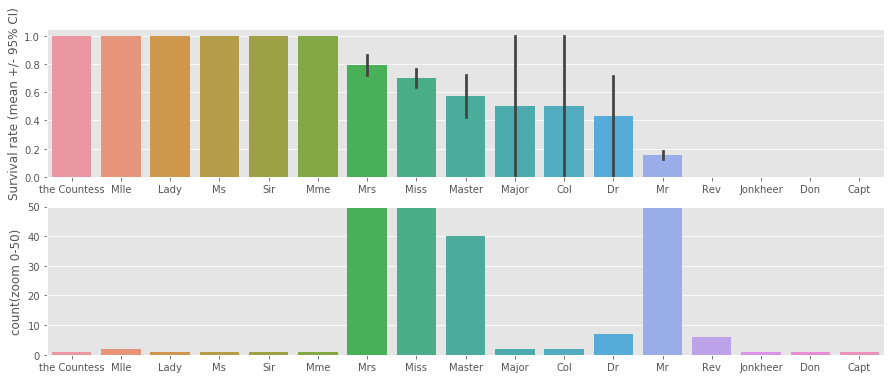

In [16]:
df_train['Title'] = df_train['Name'].map(lambda name: re.split(',.|\.', name)[1]).astype('category')
title_order = df_train.groupby('Title')['Survived'].mean().sort_values(ascending=False).index
fig, axarr = plt.subplots(2, 1, figsize=(15, 6))
sns.catplot(x='Title', y='Survived', data=df_train, ax=axarr[0], order=title_order, kind='bar')
axarr[0].set(xlabel='', ylabel='Survival rate (mean +/- 95% CI)')
sns.countplot(x='Title', data=df_train, ax=axarr[1], order=title_order)
axarr[1].set_ylim({0,50})
axarr[1].set(xlabel='', ylabel='count(zoom 0-50)')
plt.close(2)
plt.show()

In [17]:
display(df_train["Title"].value_counts())

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Don               1
the Countess      1
Lady              1
Sir               1
Mme               1
Ms                1
Capt              1
Name: Title, dtype: int64

Title feature is a bit tricky here because of the very low number of instances for each specific title. Only Miss and Master are well enough represented among the passengers and seem to present an interest in comparison with respectively Mrs and Mr common titles. Later we might want to recode the categories of this feature.

#### **Continuous numeric features**

*Survival Rate VS Age and Fare*

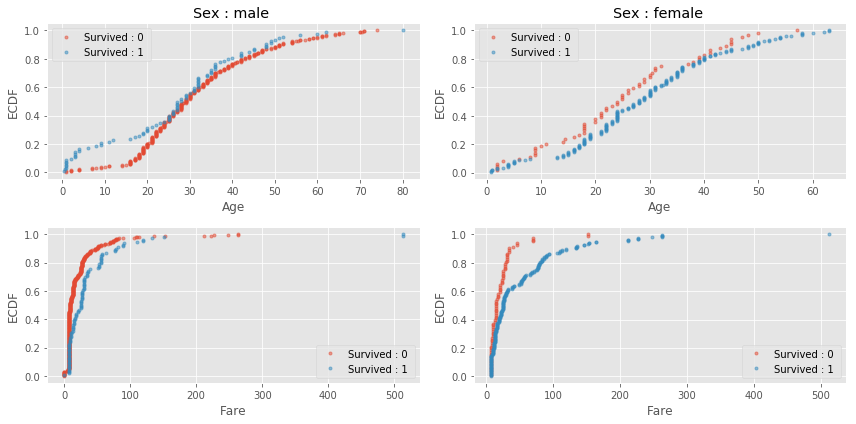

In [18]:
fig, axarr = plt.subplots(2, 2, figsize=(12, 6))
ecdf_d = {}
for idx, c in enumerate(['Age', 'Fare']):
    for idy, s in enumerate(df_train.Sex.unique()):
        ax = axarr[idx, idy]
        for k in df_train.Survived.unique():
            ecdf_d['ECDF_{Sex}_{Survived}'.format(Sex=s, Survived=k)] = ECDF(
                df_train.loc[(df_train['Sex'] == s) & (df_train['Survived'] == k), c].dropna().values)
            ax.plot(ecdf_d['ECDF_{Sex}_{Survived}'.format(Sex=s, Survived=k)].x,
                    ecdf_d['ECDF_{Sex}_{Survived}'.format(Sex=s, Survived=k)].y,
                    '.', linestyle='none', label='Survived : {} '.format(k), alpha=0.5,
                    )
            if idx == 0:
                ax.set(title='Sex : {} '.format(s), xlabel=c, ylabel='ECDF')
            else:
                ax.set(xlabel=c, ylabel='ECDF')
            ax.legend(loc='best')
plt.tight_layout()
plt.show()

ECDFs for Age enlighten different statements according to Sex :

- Men : proportion of young boy (below 15) is much more important among survivors. After 25, age distributions appear to be roughly similar between survivors and deceased <br>
- Woman : An opposite trend could be observed within women (red curve above blue curve). Women who survived the shipwreck tend to be slighlty older. This is consistent with the small decrease of mean survival rate observed for the "Miss" title in comparison with "Mrs" title.



ECDFs observed for the Fare are consistent with previous statements for Pclass and indicated that people with high fare ticket were more prone to survive. This is particularly true if you consider fare above 50 £.

For age, we might later want to convert the continuous numeric feature into categoricical feature. Relying on top ECDFs, bucket 0-15 seems interesting. We could keep the same bucket size for the whole distribution. Let's have a closer look at the mean survival rates along age categories.


In [19]:
df_train['Age_bucket'] = np.clip(df_train['Age']//15 * 15, a_max=60, a_min=None)
display(df_train.groupby(by=['Sex', 'Age_bucket'])['Survived'].mean())

Sex     Age_bucket
female  0.0           0.615385
        15.0          0.750000
        30.0          0.807692
        45.0          0.781250
        60.0          1.000000
male    0.0           0.538462
        15.0          0.151515
        30.0          0.204380
        45.0          0.192982
        60.0          0.136364
Name: Survived, dtype: float64

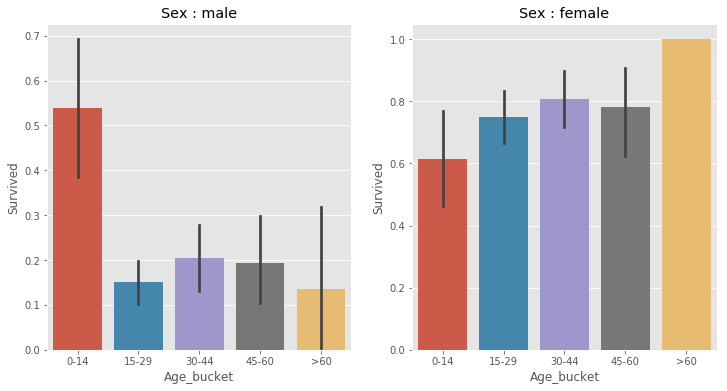

In [20]:
x_tick_lab = ['0-14', '15-29', '30-44', '45-60', '>60']
fig, axarr = plt.subplots(1, 2, figsize=(12, 6))
sns.catplot(x='Age_bucket', y='Survived', data=df_train.loc[df_train['Sex'] == 'male', ], kind='bar', ax=axarr[0])
axarr[0].set(title='Sex : male', xticklabels=x_tick_lab)
sns.catplot(x='Age_bucket', y='Survived', data=df_train.loc[df_train['Sex'] == 'female', ], kind='bar', ax=axarr[1])
axarr[1].set(title='Sex : female', xticklabels=x_tick_lab)
plt.close(2)
plt.close(3)


### **Preprocessing the data**

We will need to build a few transformers so we could handle data preprocessing in pipeline ! This concerns feature creation and missing value imputing.

#### **Feature Adder : Family, Title and Age bucket**

In [21]:
class FeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_family=True, relevant_nb=3):
        self.add_family = add_family
        self.relevant_nb = relevant_nb
    def fit(self, df, y=None):
        return (self)
    def transform(self, df, y=None):
        df['Title'] = df['Name'].map(lambda name: re.split(',.|\.', name)[1])
        df.loc[(df['Title'] == 'Ms') | (df['Title'] == 'Mlle'), 'Title'] = 'Miss'
        if self.add_family:
            df['Family'] = df['SibSp'] + df['Parch']
            fam_d = {n: "small_fam" if n < self.relevant_nb else "large_fam" for n in df['Family'].unique()}
            fam_d[0] = 'single'  
            df['Family'] = df['Family'].map(fam_d)
        return(df)

In [22]:
class AgeBucketAdder(BaseEstimator, TransformerMixin):
    def __init__(self, bucket_size=15, bucket_cap=60):
        self.bucket_size = bucket_size
        self.bucket_cap = bucket_cap
    def fit(self, df, y=None):
        return (self)
    def transform(self, df, y=None):
        df['Age_bucket'] = np.clip(df['Age']//self.bucket_size * self.bucket_size, a_max=self.bucket_cap, a_min=None)
        return(df)

I need to seperate Age_bucket from other features to add because I will build an imputer for Age missing values based on Title...

#### **Custom Age Imputer**

From what I read on Kaggle, several imputing stategies were studied for missing Age values and a simple imputer with a median strategy should work just fine. For the sake of the exercise and a bit of practising with pandas, I will go for a custom imputer based on Title. Most of titles found for train set denote social or professional status and hence, according to me, contain some information about the age.

In [23]:
class CustomAgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self, feature_name='Age', group_by_title=True, imp_func=np.nanmedian):
        self.feature_name = feature_name
        self.group_by_title = group_by_title
        self.imp_func = imp_func
    def fit(self, df, y=None):
        self.df_median = df.groupby(['Title'])[self.feature_name].agg(self.imp_func)
        self.med_M = self.imp_func(df.loc[df['Sex'] == 'male', 'Age'])
        self.med_F = self.imp_func(df.loc[df['Sex'] == 'female', 'Age'])
        return self
    def transform(self, df, y=None):
        if self.group_by_title:
            for title in df['Title'].unique():
                if title in self.df_median.dropna().index:
                    df.loc[(df['Title'] == title) & (df[self.feature_name].isna()), self.feature_name] = self.df_median[title] 
                    #filna method with inplace not working here... should investigate what's wrong later for nicer code
                else:
                    df.loc[(df['Title'] == title) & (df['Sex'] == 'male') & (df[self.feature_name].isna()), self.feature_name] = self.med_M
                    df.loc[(df['Title'] == title) & (df['Sex'] == 'female') & (df[self.feature_name].isna()), self.feature_name] = self.med_F
        else:
            df.loc[(df['Sex'] == 'male') & (df[self.feature_name].isna()), self.feature_name] = self.med_M
            df.loc[(df['Sex'] == 'female') & (df[self.feature_name].isna()), self.feature_name] = self.med_F
        return df

In [24]:
# Inspired from stackoverflow.com/questions/25239958 and copy from https://github.com/ageron/handson-ml/blob/master/03_classification.ipynb
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        self.most_frequent_ = pd.Series([df[c].value_counts().index[0] for c in df],
                                        index=df.columns)
        return self
    def transform(self, df, y=None):
        return df.fillna(self.most_frequent_)



#### **DataFrame Selector**

Let's finally add a DataFrame Selector Class so we can easily select relevant features within pipelines later if needed

In [25]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names]

#### **Pipelines**

One last step before training models, we need to build the preprocessing pipelines

In [26]:
add_imp_pipeline = Pipeline([('feat_add', FeatureAdder()),
                             ('age_imp', CustomAgeImputer()),
                             ('age_bucket_add', AgeBucketAdder())])

num_features = ['Fare']
cat_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Family', 'Age_bucket'] #not sure if Embarked is relevant. We'll see that later.
feat_l = [[1, 2], ['female'], ['S', 'C'], ['Master', 'Miss'], ['single', 'sm_fam'], [0.0, 15.0, 30.0, 45.0]]

num_pipeline = Pipeline([
    ('num_imp', SimpleImputer(strategy='median')), #could have build imp based on pclass but no missing value for Fare in test set
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cat_imp', MostFrequentImputer()),
    ('enc', OneHotEncoder(sparse=False, handle_unknown='ignore', categories=feat_l))
])

union_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

preproc_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline)
])

Let's give a try and check that everything looks fine

In [27]:
datasets = fetch_datasets()
df_train = datasets['train.csv']
df_prep = df_train.copy()
df_test = datasets['test.csv']


Files were previously downloaded, loading file from:  ./Data/


In [28]:
X_prep = preproc_pipeline.fit_transform(df_prep)

In [29]:
col_name = num_features + list(itertools.chain.from_iterable(feat_l))
print(X_prep.shape)
display(pd.DataFrame(X_prep, columns=col_name).head(10))

(891, 14)


,Fare,1,2,female,S,C,Master,Miss,single,sm_fam,0.0,15.0,30.0,45.0
0,-0.502445,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.786845,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.488854,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.420730,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.486337,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5,-0.478116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,0.395814,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7,-0.224083,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,-0.424256,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,-0.042956,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


Finally.... Everything looks fine and it will be very simple to modify or even tune preprocessing parameters thanks to pipelines. 

### **Training models**

#### **Short-list of promising models**

In [30]:
y_train = df_train['Survived']


In [31]:
algo_d = {'knn': KNeighborsClassifier(),
          'lin_svm': LinearSVC(loss='hinge'),
          'svm': SVC(gamma='auto'),
          'logit': LogisticRegression(),
          'dt': DecisionTreeClassifier(random_state=42),
          'rf': RandomForestClassifier(random_state=42),
          'mlp': MLPClassifier(random_state=42),
          }
scores_d = {}
for key, value in algo_d.items():
    full_pipeline = Pipeline([
        ('prep', add_imp_pipeline),
        ('union', union_pipeline),
        (key, value)
    ])
    print(value)
    scores = cross_val_score(full_pipeline, df_train, y_train, cv=10, n_jobs=-1)
    scores_d[key] = scores
    print('Mean Accury scores for {} : {}'.format(key, scores.mean()))
    print('~-' * 30)

nb_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('df_sel', DataFrameSelector(feature_names=cat_features)),
    ('cat', cat_pipeline),
    ('b_nb', BernoulliNB())
])
print(BernoulliNB())
scores = cross_val_score(nb_pipeline, df_train, y_train, cv=10, n_jobs=-1)
print('Mean Accury scores for {} : {}'.format('nb_clf', scores.mean()))
scores_d['b_nb'] = scores


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')
Mean Accury scores for knn : 0.7823921802292588
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0)
Mean Accury scores for lin_svm : 0.7934777550788786
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Mean Accury scores for svm : 0.7844884235614572
~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-~-
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True

Text(0, 0.5, 'Accuracy')

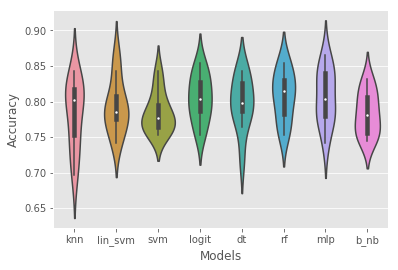

In [32]:
df_score = pd.DataFrame(scores_d).stack().reset_index()
g = sns.violinplot(df_score['level_1'], df_score[0])
g.set_xlabel('Models')
g.set_ylabel('Accuracy')

Since binary class proportion for the target feature is rather balanced (~40 VS ~60), accuracy is not too bad as a metric for classifier evaluation. ROC curves, auc scores could have been another option.<br>
However, 10 fold cross-val scores for accuracy may varie a lot among a single classifier. Thus the median or the violin-box distribution might be a intereresting complement for the cross-val score estimation in addition of average score. Inter-clf score distributions and medians remain roughly similar, and thus it is tricky to establish a short-list of most-promising models. <br> <br>
Here the dataset is pretty small and I will go with all the previous classifiers except DT (random forest should perform at least just as well) and naive_bayes bernoulli.

#### **Fine-tuning classifiers**

*Random Forests*

In [33]:
full_pipeline = Pipeline([
        ('prep', add_imp_pipeline),
        ('union', union_pipeline),
        ('rf', RandomForestClassifier(random_state=42))
])

param_dist = {'rf__n_estimators': [1000], 'rf__max_features': uniform(0.2, 0.7), 'rf__max_depth': randint(2, 9)}

R_cv = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, scoring='accuracy', n_iter=50, 
                          n_jobs=-1, verbose=2, cv=5, random_state=42)
R_cv.fit(df_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...rs='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'rf__n_estimators': [1000], 'rf__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C86F77BDD8>, 'rf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C86F7A7470>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [34]:
print(R_cv.best_score_, R_cv.best_params_)

0.8383838383838383 {'rf__max_depth': 7, 'rf__max_features': 0.848661206055656, 'rf__n_estimators': 1000}


In [35]:
def model_saver(model, saving_name, saving_path=MODEL_SAVING_PATH):
    from sklearn.externals import joblib
    os.makedirs(MODEL_SAVING_PATH, exist_ok=True)
    joblib.dump(model, os.path.join(saving_path, saving_name))
    print('Model saved in ', saving_path)

In [36]:
model_saver(R_cv.best_estimator_, 'rf_clf.pkl')

Model saved in  ./Models/


Let's have a look to mean feature importances computed for Random Forests. 

In [37]:
feature_importances = R_cv.best_estimator_.steps[2][1].feature_importances_ #3rd step in pipeline, 2nd element for estimator
print(sorted(list(zip(feature_importances, col_name)), reverse=True))

[(0.41423963289229854, 'female'), (0.2570248623117338, 'Fare'), (0.08181752544240835, 2), (0.07263040572797998, 1), (0.03952706451353138, 'Master'), (0.034386937954674554, 'Miss'), (0.020229231347220416, 'S'), (0.018610233182737666, 0.0), (0.015741908469049666, 15.0), (0.014104521529181787, 'single'), (0.012850585114821917, 30.0), (0.009985026768412836, 'C'), (0.008852064745948816, 45.0), (0.0, 'sm_fam')]


We should also give a try to some extra randomness with Extra-trees performing using random tresholds for features at splitting.

In [38]:
full_pipeline = Pipeline([
        ('prep', add_imp_pipeline),
        ('union', union_pipeline),
        ('ext_tr', ExtraTreesClassifier(random_state=42))
])

param_dist = {'ext_tr__n_estimators': [1000], 'ext_tr__max_features': uniform(0.2, 0.7), 'ext_tr__max_depth': randint(2, 10)}

R_cv = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, scoring='accuracy', n_iter=50, 
                          n_jobs=-1, verbose=2, cv=5, random_state=42)
R_cv.fit(df_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...ors='warn', n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'ext_tr__n_estimators': [1000], 'ext_tr__max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C86F3B9390>, 'ext_tr__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C86F3B9D30>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [39]:
print(R_cv.best_score_, R_cv.best_params_)

0.8215488215488216 {'ext_tr__max_depth': 5, 'ext_tr__max_features': 0.856986896311025, 'ext_tr__n_estimators': 1000}


In [40]:
model_saver(R_cv.best_estimator_, 'ext_tr_clf.pkl')

Model saved in  ./Models/


Let's define a final feature selector for other classifier pipelines using ordered feature importances from Random Forests.

In [41]:
def top_feat_k(l, k, rev=True): 
    l_zip = list(zip(l, range(len(l))))
    l_zip.sort(reverse=rev)
    l_ix = [l_zip[x][1] for x in range(len(l))]
    return (l_ix[0:k])

In [42]:
class FinalFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feat_import=feature_importances, k=len(feature_importances)):
        self.k = k
        self.feat_import = feat_import
    def fit(self, X, y=None):
        return(self)
    def transform(self, X, y=None):
        return X[:, top_feat_k(l=self.feat_import, k=self.k)]

*Knn*

In [43]:
full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('feat_sel', FinalFeatureSelector(feat_import=feature_importances)),
    ('knn', KNeighborsClassifier())
])
param = {'knn__n_neighbors': range(3, 10), 'feat_sel__k': range(3, len(feature_importances)+1)}
G_cv = GridSearchCV(full_pipeline, param_grid=param, scoring='accuracy', n_jobs=-1, verbose=2, cv=5)
G_cv.fit(df_train, y_train)


Fitting 5 folds for each of 84 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  4.9min finished
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'knn__n_neighbors': range(3, 10), 'feat_sel__k': range(3, 15)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [44]:
print(G_cv.best_score_, G_cv.best_params_)

0.8249158249158249 {'feat_sel__k': 5, 'knn__n_neighbors': 8}


In [45]:
model_saver(G_cv.best_estimator_, 'knn_clf.pkl')

Model saved in  ./Models/


*RBF SVM*

In [46]:
full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('feat_sel', FinalFeatureSelector(feat_import=feature_importances)),
    ('svm', SVC(probability=True))#prob slow down training but useful later
])

param_dist = {'svm__kernel': ['rbf'], 'svm__C': reciprocal(1, 1000), 'svm__gamma': reciprocal(0.001, 1),
         'feat_sel__k': range(4, len(feature_importances)+1)}
R_cv = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, scoring='accuracy', n_jobs=-1, verbose=2, 
                          n_iter=100, cv=5, random_state=42)
R_cv.fit(df_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.8min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...bf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'svm__kernel': ['rbf'], 'svm__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C86F4E3D30>, 'svm__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C86F4E3C18>, 'feat_sel__k': range(4, 15)},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [47]:
print(R_cv.best_score_, R_cv.best_params_)

0.8305274971941639 {'feat_sel__k': 8, 'svm__C': 63.5835885667625, 'svm__gamma': 0.13311216080736882, 'svm__kernel': 'rbf'}


In [48]:
model_saver(R_cv.best_estimator_, 'rbf_svm_clf.pkl')

Model saved in  ./Models/


*Linear SVC*

In [49]:
full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('feat_sel', FinalFeatureSelector(feat_import=feature_importances)),
    ('svm', LinearSVC(max_iter=2000))
])

param_dist = {'svm__penalty': ['l2'], 'svm__loss': ['hinge', 'squared_hinge'], 'svm__C': reciprocal(1, 1000),
         'feat_sel__k': range(4, len(feature_importances)+1)}
R_cv = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, scoring='accuracy', n_jobs=-1, verbose=2,
                          cv=5, n_iter=100, random_state=42)
R_cv.fit(df_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.6min finished
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...ax_iter=2000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
          fit_params=None, iid='warn', n_iter=100, n_jobs=-1,
          param_distributions={'svm__penalty': ['l2'], 'svm__loss': ['hinge', 'squared_hinge'], 'svm__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C86F238B00>, 'feat_sel__k': range(4, 15)},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=2)

In [50]:
print(R_cv.best_score_, R_cv.best_params_)

0.8047138047138047 {'feat_sel__k': 10, 'svm__C': 145.48552070164158, 'svm__loss': 'squared_hinge', 'svm__penalty': 'l2'}


In [51]:
model_saver(R_cv.best_estimator_, 'lin_svm_clf.pkl')

Model saved in  ./Models/


*Logit*

In [52]:
full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('feat_sel', FinalFeatureSelector(feat_import=feature_importances)),
    ('logit', LogisticRegression())
])

param = [{'logit__penalty': ['l2'], 'logit__C': [1, 10, 30, 100],
         'feat_sel__k': range(4, len(feature_importances))},
         {'logit__penalty': ['l1'], 'logit__C': [1, 10, 30, 100],
         'feat_sel__k': range(8, len(feature_importances)+1)}] #Let lasso sparse the model
         #Should try Elasticnet penalty with scikit-learn 0.21
         
G_cv = GridSearchCV(full_pipeline, param_grid=param, scoring='accuracy', n_jobs=-1, verbose=2, cv=5)
G_cv.fit(df_train, y_train)

Fitting 5 folds for each of 68 candidates, totalling 340 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 340 out of 340 | elapsed:  3.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'logit__penalty': ['l2'], 'logit__C': [1, 10, 30, 100], 'feat_sel__k': range(4, 14)}, {'logit__penalty': ['l1'], 'logit__C': [1, 10, 30, 100], 'feat_sel__k': range(8, 15)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [53]:
print(G_cv.best_score_, G_cv.best_params_)

0.8170594837261503 {'feat_sel__k': 13, 'logit__C': 10, 'logit__penalty': 'l2'}


In [54]:
model_saver(G_cv.best_estimator_, 'logit_clf.pkl')

Model saved in  ./Models/


*Multi layer perceptron*

In [55]:
full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('feat_sel', FinalFeatureSelector(feat_import=feature_importances)),
    ('mlp', MLPClassifier(random_state=42, max_iter=300))
])

param = [{'mlp__solver': ['lbfgs'], 'mlp__hidden_layer_sizes': [100, 300, 500], 'mlp__alpha': [0.00001, 0.0001, 0.001],
          'feat_sel__k': range(5, 9)},
         {'mlp__solver': ['sgd'], 'mlp__hidden_layer_sizes': [100, 300, 500], 'mlp__alpha': [0.00001, 0.0001, 0.001],
          'mlp__early_stopping': [True, False], 'feat_sel__k': range(5, 9)},
         {'mlp__solver': ['adam'], 'mlp__hidden_layer_sizes': [100, 300, 500], 'mlp__alpha': [0.00001, 0.0001, 0.001],
          'mlp__early_stopping': [True, False], 'feat_sel__k': range(5, 9)}]
         
G_cv = GridSearchCV(full_pipeline, param_grid=param, scoring='accuracy', n_jobs=-1, verbose=2, cv=5)
G_cv.fit(df_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 17.6min finished
C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'mlp__solver': ['lbfgs'], 'mlp__hidden_layer_sizes': [100, 300, 500], 'mlp__alpha': [1e-05, 0.0001, 0.001], 'feat_sel__k': range(5, 9)}, {'mlp__solver': ['sgd'], 'mlp__hidden_layer_sizes': [100, 300, 500], 'mlp__alpha': [1e-05, 0.0001, 0.001], 'mlp__early_stopping': [True, False], 'feat_sel__k': range(5, 9)}, {'mlp__solver': ['adam'], 'mlp__hidden_layer_sizes': [100, 300, 500], 'mlp__alpha': [1e-05, 0.0001, 0.001], 'mlp__early_

In [56]:
print(G_cv.best_score_, G_cv.best_params_)

0.8338945005611672 {'feat_sel__k': 7, 'mlp__alpha': 1e-05, 'mlp__early_stopping': False, 'mlp__hidden_layer_sizes': 300, 'mlp__solver': 'adam'}


In [57]:
model_saver(G_cv.best_estimator_, 'mlp_clf.pkl')

Model saved in  ./Models/


#### **Ensemble methods**

*Voting clf*

In [58]:
algo_d = {'knn': KNeighborsClassifier(),
          'svm': SVC(gamma='auto', probability=True),
          'logit': LogisticRegression(),
          'rf': RandomForestClassifier(random_state=42),
          'mlp': MLPClassifier(random_state=42, solver='lbfgs')
          }

model_pipe_d = {}
for key, value in algo_d.items():
    full_pipeline = Pipeline([
        ('prep', add_imp_pipeline),
        ('union', union_pipeline),
        (key, value)
    ])
    model_pipe_d[key] = full_pipeline
    
nb_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('df_sel', DataFrameSelector(feature_names=cat_features)),
    ('cat', cat_pipeline),
    ('b_nb', BernoulliNB())
])

model_pipe_d['bnb'] = nb_pipeline

estimators = [(key, value) for key, value in model_pipe_d.items()]
print(estimators)

[('knn', Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...ki',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))])), ('svm', Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])), ('logit', Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(ad

In [59]:
hard_voting_clf = VotingClassifier(estimators=estimators, voting='hard')
h_scores = cross_val_score(hard_voting_clf, df_train, y_train, cv=10, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   29.5s finished


In [60]:
soft_voting_clf = VotingClassifier(estimators=estimators, voting='soft')
s_scores = cross_val_score(soft_voting_clf, df_train, y_train, cv=10, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   30.7s finished


In [61]:
print('Mean Accury scores for {} : {}'.format('hard_voting_clf', h_scores.mean()))
print('Mean Accury scores for {} : {}'.format('soft_voting_clf', s_scores.mean()))

Mean Accury scores for hard_voting_clf : 0.8170993644308251
Mean Accury scores for soft_voting_clf : 0.8160015889229373


In [62]:
trained_models_vot = [os.path.join(MODEL_SAVING_PATH, file_name)for file_name in 
                      ('knn_clf.pkl', 'logit_clf.pkl', 'mlp_clf.pkl', 'rf_clf.pkl', 'rbf_svm_clf.pkl')]
print(trained_models_vot)

['./Models/knn_clf.pkl', './Models/logit_clf.pkl', './Models/mlp_clf.pkl', './Models/rf_clf.pkl', './Models/rbf_svm_clf.pkl']


In [63]:
trained_estimators = [(key, joblib.load(key)) for key in trained_models_vot]
for estimator in trained_estimators:
    print("\n", estimator)


 ('./Models/knn_clf.pkl', Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...ki',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform'))]))

 ('./Models/logit_clf.pkl', Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]))

 ('./Models/mlp_clf.pkl', Pipeline(memory=None,
     steps=[('prep', Pipeline

In [64]:
hard_voting_clf = VotingClassifier(estimators=trained_estimators, voting='hard')
h_scores = cross_val_score(hard_voting_clf, df_train, y_train, cv=10, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   32.9s finished


In [65]:
print('Mean Accury scores for {} : {}'.format('hard_voting_clf', h_scores.mean()))

Mean Accury scores for hard_voting_clf : 0.8362010554988082


In [66]:
hard_voting_clf.fit_transform(df_train, y_train)
model_saver(hard_voting_clf, 'hard_voting_clf.pkl')

C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Model saved in  ./Models/


*Bagging/Pasting*

See Random Forests & Extra-Trees

*Boosting: AdaBoost*

In [67]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)
full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('ada_clf', ada_clf)
])

In [68]:
scores = cross_val_score(full_pipeline, df_train, y_train, cv=10, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.6s finished


In [69]:
print('Mean Accury scores for {} : {}'.format('ada_clf (Decision stumps)', scores.mean()))

Mean Accury scores for ada_clf (Decision stumps) : 0.8260381908977413


In [70]:
ada_clf = AdaBoostClassifier(algorithm="SAMME.R")
dt_1 = DecisionTreeClassifier(max_depth=1)
dt_2 = DecisionTreeClassifier(max_depth=2)


full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('feat_sel', FinalFeatureSelector()),
    ('ada_clf', ada_clf)
])

param = {'ada_clf__base_estimator': [dt_1, dt_2], 'ada_clf__n_estimators': [100, 200, 300, 400], 
         'ada_clf__learning_rate': [0.5, 0.75, 1], 'feat_sel__k': range(8, len(feature_importances)+1)}

G_cv = GridSearchCV(full_pipeline, param_grid=param, scoring='accuracy', n_jobs=-1, verbose=2, cv=5)
G_cv.fit(df_train, y_train)

Fitting 5 folds for each of 168 candidates, totalling 840 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 840 out of 840 | elapsed: 11.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...m='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'ada_clf__base_estimator': [DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_we...ators': [100, 200, 300, 400], 'ada_clf__learning_rate': [0.5, 0.75, 1], 'feat_sel__k': range(8, 15)},
       pre_dispatch='2*n_jobs', refit=T

In [71]:
print(G_cv.best_score_, G_cv.best_params_)

0.8282828282828283 {'ada_clf__base_estimator': DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'), 'ada_clf__learning_rate': 1, 'ada_clf__n_estimators': 400, 'feat_sel__k': 11}


In [72]:
model_saver(G_cv.best_estimator_, 'ada_clf.pkl')

Model saved in  ./Models/


*Boosting: Extreme Gradient Boosting*

In [73]:
xgb_clf = xgb.XGBClassifier()
full_pipeline = Pipeline([
    ('prep', add_imp_pipeline),
    ('union', union_pipeline),
    ('feat_sel', FinalFeatureSelector()),
    ('xgb_clf', xgb_clf)
])
param_dist = {'xgb_clf__n_estimators': randint(100, 150), "xgb_clf__max_depth": randint(2, 7), 'xgb_clf__subsample': uniform(0.6, 0.3),
              'xgb_clf__colsammple_bytree': uniform(0.7, 0.3), 'xgb_clf__gamma': expon(0, 5), 'xgb_clf__eta': uniform(0.03, 0.3),
              'feat_sel__k': range(8, len(feature_importances)+1)}

R_cv = RandomizedSearchCV(full_pipeline, param_distributions=param_dist, n_iter=300, cv=5, verbose=2, n_jobs=-1, random_state=42)
R_cv.fit(df_train, y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 20.3min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))]),
          fit_params=None, iid='warn', n_iter=300, n_jobs=-1,
          param_distributions={'xgb_clf__n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C870CB7DA0>, 'xgb_clf__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001C870CB77F0>, 'xgb_clf__subsample': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0...py.stats._distn_infrastructure.rv_frozen object at 0x000001C870CAB5C0>, 'feat_sel__k': range(8, 15)},
          pr

In [74]:
print(R_cv.best_score_, R_cv.best_params_)

0.8439955106621774 {'feat_sel__k': 12, 'xgb_clf__colsammple_bytree': 0.8920008900510741, 'xgb_clf__eta': 0.097410353091804, 'xgb_clf__gamma': 0.9923183371506022, 'xgb_clf__max_depth': 4, 'xgb_clf__n_estimators': 104, 'xgb_clf__subsample': 0.6309926871372047}


Let's have a quick look at our hyper parameter search space

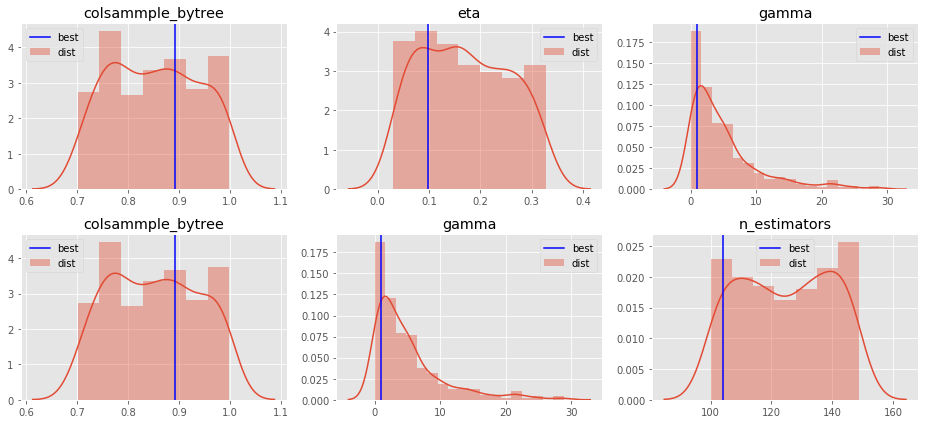

In [75]:
fig, axarr = plt.subplots(2, 3, figsize=(13, 6))
for i in range(2):
    for j in range(3):
        key = list(R_cv.best_params_.keys())[j + i*j +1] #+1 to skip feat_sel
        best_val = R_cv.best_params_[key]
        ax = axarr[i, j]
        sns.distplot(R_cv.cv_results_['param_'+key].filled().astype(np.float32), ax=ax)
        ax.set_title(re.split('__', key)[1])
        ax.axvline(x=best_val, c="blue")
        ax.legend(['best', 'dist'])
plt.tight_layout()
plt.show()

In [76]:
model_saver(R_cv.best_estimator_, 'xgb_clf.pkl')

Model saved in  ./Models/


*Stacking*

Let's try to build a singlelayer stacking ensemble

In [77]:
trained_models_path = [os.path.join(MODEL_SAVING_PATH, file_name)for file_name in 
                      ('knn_clf.pkl', 'logit_clf.pkl', 'mlp_clf.pkl', 'rf_clf.pkl', 'rbf_svm_clf.pkl')]
tuned_estimators = [(key, joblib.load(key)) for key in trained_models_path]

In [78]:
first_layer_predictions = []
for tuple in tuned_estimators:
    estimator = tuple[1]
    print("\n", estimator)
    y_pred = cross_val_predict(estimator, df_train, y_train, method='predict_proba', n_jobs=-1, cv=5)
    first_layer_predictions.append(y_pred[:, 1]) #cross val predict return proba for each class 

    



 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...ki',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform'))])

 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_n

C:\Users\ghare\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning



 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...tors=1000, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False))])

 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...bf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])


In [79]:
blender_train_set = np.array(first_layer_predictions).T
display(blender_train_set)

array([[0.        , 0.05585816, 0.10949213, 0.07344884, 0.17815104],
       [1.        , 0.96781561, 0.98793834, 0.993     , 0.88581555],
       [0.625     , 0.50862372, 0.33238464, 0.36735851, 0.1780791 ],
       ...,
       [0.625     , 0.47182458, 0.27934757, 0.31081835, 0.20095701],
       [0.625     , 0.58732617, 0.31648037, 0.56822358, 0.20545482],
       [0.        , 0.11756442, 0.1012727 , 0.05232193, 0.20507301]])

In [80]:
rf_blender_clf = RandomForestClassifier(oob_score=True, n_jobs=-1, n_estimators=1000, random_state=42)
rf_blender_clf.fit(blender_train_set, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)

In [81]:
print(rf_blender_clf.oob_score_)

0.813692480359147


In [82]:
max_depths = [1, 2, 3]
max_features = [3, 4, 5]
cv_results = []
for max_depth in max_depths:
    for max_feature in max_features:
        rf_blender_clf = RandomForestClassifier(oob_score=True, n_jobs=-1, n_estimators=1000, random_state=42,
                                                max_features=max_feature, max_depth=max_depth)
        rf_blender_clf.fit(blender_train_set, y_train)
        cv_results.append({"max_depth" : max_depth, "max_features": max_feature, "oob_score" : rf_blender_clf.oob_score_})

In [83]:
cv_df = pd.DataFrame(cv_results)
cv_df.sort_values(by='oob_score', ascending=False, inplace=True)
display(cv_df)

,max_depth,max_features,oob_score
2,1,5,0.839506
1,1,4,0.837262
8,3,5,0.833895
6,3,3,0.831650
7,3,4,0.831650
3,2,3,0.827160
5,2,5,0.827160
0,1,3,0.824916
4,2,4,0.824916


In [84]:
rf_blender_clf = RandomForestClassifier(oob_score=True, n_jobs=-1, n_estimators=1000, random_state=42, max_depth=1, max_features=5)
rf_blender_clf.fit(blender_train_set, y_train)
model_saver(rf_blender_clf, 'rf_blender_clf.pkl')

Model saved in  ./Models/


In [85]:
feature_importances = rf_blender_clf.feature_importances_ 
print(sorted(list(zip(feature_importances, ['knn_clf', 'logit_clf', 'mlp_clf', 'rf_clf', 'rbf_svm_clf'])), reverse=True))

[(0.608, 'rf_clf'), (0.335, 'mlp_clf'), (0.032, 'rbf_svm_clf'), (0.02, 'knn_clf'), (0.005, 'logit_clf')]


### **Predicting test set & preparing submissions**

In [86]:
y_pred = R_cv.predict(df_test)


In [87]:
id_values = df_test.index.values

In [88]:
def Kaggle_sub(y_values, id_key='PassengerId', id_values=id_values, y_key='Survived', save_path='./Submissions', name='final_sub'):
    df_sub = pd.DataFrame({id_key: id_values, y_key: y_values})
    os.makedirs(save_path, exist_ok=True)
    df_sub.to_csv(os.path.join(save_path, name+'.csv'), index=False)
    print('{} was saved at {}'.format(name, save_path))


In [89]:
Kaggle_sub(y_values=y_pred, name='xgb_clf')

xgb_clf was saved at ./Submissions


In [90]:
model_file_paths = [os.path.join(MODEL_SAVING_PATH, file) for file in os.listdir(MODEL_SAVING_PATH)]
model_names = [re.search('/\w*/(.*?)\.pkl', file_path).group(1) for file_path in model_file_paths]
model_file_paths.remove('./Models/rf_blender_clf.pkl')#need to prepare df_test prior to predictions


In [91]:
for i in range(len(model_file_paths)):
    model = joblib.load(model_file_paths[i])
    y_pred = model.predict(df_test)
    Kaggle_sub(name=model_names[i], y_values=y_pred)

ada_clf was saved at ./Submissions
ext_tr_clf was saved at ./Submissions
hard_voting_clf was saved at ./Submissions
knn_clf was saved at ./Submissions
lin_svm_clf was saved at ./Submissions
logit_clf was saved at ./Submissions
mlp_clf was saved at ./Submissions
rbf_svm_clf was saved at ./Submissions
rf_blender_clf was saved at ./Submissions
rf_clf was saved at ./Submissions


Let's finally get predictions on test set for the rf blender trained earlier.

In [92]:
first_layer_predictions_test = []
for tuple in tuned_estimators:
    estimator = tuple[1]
    print("\n", estimator)
    y_pred = estimator.predict_proba(df_test)
    first_layer_predictions_test.append(y_pred[:, 1]) #cross val predict return proba for each class 



 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...ki',
           metric_params=None, n_jobs=None, n_neighbors=8, p=2,
           weights='uniform'))])

 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_nb=3)), ('age_imp', CustomAgeImputer(feature_name='Age', group_by_title=True,
         imp_func=<function nanmedian at 0x000001C869560B70>)), ('age_bucket_add', AgeBucketAdder(bucket_cap=60, bucket_...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

 Pipeline(memory=None,
     steps=[('prep', Pipeline(memory=None,
     steps=[('feat_add', FeatureAdder(add_family=True, relevant_n

In [93]:
blender_test_set = np.array(first_layer_predictions_test).T
display(blender_test_set)

array([[0.125     , 0.0973147 , 0.11533647, 0.09808368, 0.18084736],
       [0.875     , 0.39042611, 0.58902918, 0.41912481, 0.31562791],
       [0.        , 0.16138245, 0.14728242, 0.1249521 , 0.18077995],
       ...,
       [0.        , 0.0639328 , 0.11133759, 0.04425423, 0.18083837],
       [0.25      , 0.0639633 , 0.10824612, 0.12299177, 0.18084209],
       [0.5       , 0.59787291, 0.48131907, 0.3835006 , 0.42147026]])

In [94]:
y_pred = rf_blender_clf.predict(blender_test_set)
Kaggle_sub(y_values=y_pred, name='rf_blender_clf')


rf_blender_clf was saved at ./Submissions
